In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn, optim
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision import models, datasets, transforms
from torchinfo import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
dir(models.detection)

['FCOS',
 'FCOS_ResNet50_FPN_Weights',
 'FasterRCNN',
 'FasterRCNN_MobileNet_V3_Large_320_FPN_Weights',
 'FasterRCNN_MobileNet_V3_Large_FPN_Weights',
 'FasterRCNN_ResNet50_FPN_V2_Weights',
 'FasterRCNN_ResNet50_FPN_Weights',
 'KeypointRCNN',
 'KeypointRCNN_ResNet50_FPN_Weights',
 'MaskRCNN',
 'MaskRCNN_ResNet50_FPN_V2_Weights',
 'MaskRCNN_ResNet50_FPN_Weights',
 'RetinaNet',
 'RetinaNet_ResNet50_FPN_V2_Weights',
 'RetinaNet_ResNet50_FPN_Weights',
 'SSD300_VGG16_Weights',
 'SSDLite320_MobileNet_V3_Large_Weights',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'anchor_utils',
 'backbone_utils',
 'faster_rcnn',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcos',
 'fcos_resnet50_fpn',
 'generalized_rcnn',
 'image_list',
 'keypoint_rcnn',
 'keypointrcnn_resnet50_fpn',
 'mask_rcnn',
 'maskrcnn_resnet50_fpn'

In [8]:
weights = models.detection.SSD300_VGG16_Weights.COCO_V1
ssd300 = models.detection.ssd300_vgg16(weights=weights)

In [9]:
print(ssd300)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [10]:
summary(ssd300, (1, 3, 300, 300))

Layer (type:depth-idx)                   Output Shape              Param #
SSD                                      [99, 4]                   --
├─GeneralizedRCNNTransform: 1-1          [1, 3, 300, 300]          --
├─SSDFeatureExtractorVGG: 1-2            [1, 256, 1, 1]            512
│    └─Sequential: 2-1                   [1, 512, 38, 38]          --
│    │    └─Conv2d: 3-1                  [1, 64, 300, 300]         (1,792)
│    │    └─ReLU: 3-2                    [1, 64, 300, 300]         --
│    │    └─Conv2d: 3-3                  [1, 64, 300, 300]         (36,928)
│    │    └─ReLU: 3-4                    [1, 64, 300, 300]         --
│    │    └─MaxPool2d: 3-5               [1, 64, 150, 150]         --
│    │    └─Conv2d: 3-6                  [1, 128, 150, 150]        73,856
│    │    └─ReLU: 3-7                    [1, 128, 150, 150]        --
│    │    └─Conv2d: 3-8                  [1, 128, 150, 150]        147,584
│    │    └─ReLU: 3-9                    [1, 128, 150, 150]     

In [11]:
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor()
])

In [13]:
dataset = datasets.VOCDetection(root='./VOC_dataset/VOC2012',
                                year='2012',
                                image_set='val',
                                download=True,
                                transform=transform)

100%|██████████| 1999639040/1999639040 [05:48<00:00, 5743408.34it/s] 


Extracting ./VOC_dataset/VOC2012\VOCtrainval_11-May-2012.tar to ./VOC_dataset/VOC2012


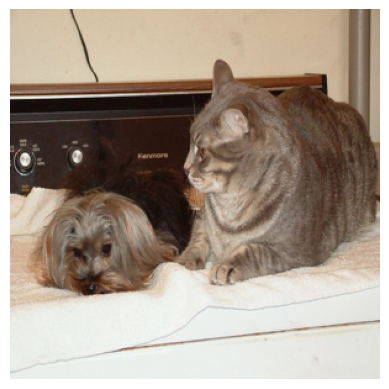

In [17]:
idx = torch.randint(len(dataset), size=(1,))
image, annotation = dataset[idx.item()]

plt.imshow(image.permute(1, 2, 0))
plt.grid(None)
plt.axis('off')
plt.show()

In [18]:
import time

idx = torch.randint(len(dataset), size=(1, ))
image_jpg, annotation = dataset[idx.item()]
image = image_jpg.unsqueeze(0).to(device)

ssd300.eval()
start = time.time()
with torch.no_grad():
    prediction = ssd300(image)
stop = time.time()
print((stop - start)*1000)

300.81892013549805


In [22]:
prediction = prediction[0]
print(prediction)

{'boxes': tensor([[143.0190,  54.2042, 295.9579, 155.3154],
        [ 15.8532,  53.1952, 144.1798, 145.6502],
        [ 34.9037,  79.8600,  51.0293, 104.7479],
        [ 46.0192,  79.8776,  56.6649, 105.5397],
        [122.7088,  87.1981, 138.5763, 106.2380],
        [ 29.8290,  78.7166,  44.7443, 105.6780],
        [172.5644,  80.1393, 186.8602, 106.6118],
        [ 56.0122,  81.5218,  64.7391, 108.1133],
        [209.4703,  87.2019, 217.4247, 103.0382],
        [248.1040,  88.2068, 256.2555, 103.0187],
        [ 64.3920,  82.9715,  72.3943, 109.4571],
        [215.8993,  87.6894, 223.8863, 102.4038],
        [ 86.3188,  84.9355,  95.6711, 104.2449],
        [104.5521,  86.7081, 112.9132, 104.5107],
        [ 80.8510,  84.5161,  89.1741, 105.3288],
        [ 97.2138,  85.6582, 104.3547, 103.7523],
        [212.2720,  91.8613, 218.5129, 103.0193],
        [256.4223,  88.8795, 264.1264, 102.8075],
        [ 71.7902,  83.5523,  79.6573, 107.8399],
        [240.4248,  88.0025, 248.2927, 1

[143, 54, 295, 155]
[15, 53, 144, 145]


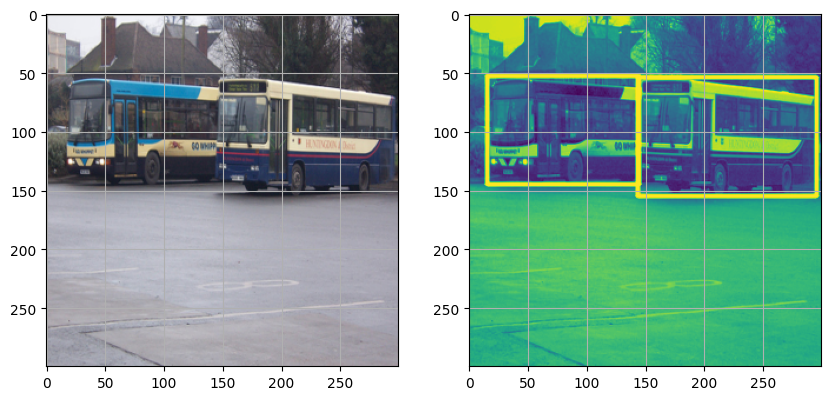

In [ ]:
image = image.cpu().data[0]
image = transforms.functional.to_pil_image(image)
image = np.array(image)

threshold = 0.5

for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
    if score > threshold:
        box = list(map(int, box))
        print(box)
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2, cv2.LINE_AA)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image_jpg.permute(1, 2, 0))
axs[0].grid(None)
axs[1].imshow(image)
axs[1].grid(None)
plt.show()

In [38]:
import numpy as np
import sys
import cv2
import pandas as pd
img = cv2.imread('./figure/king_face.png')

if img is None:
    print('image read failed')
    sys.exit()

model = './opencv_face_detector/opencv_face_detector_uint8.pb'
config = './opencv_face_detector/opencv_face_detector.pbtxt'

face_net = cv2.dnn.readNet(model, config)

if face_net.empty():
    print('Net open failed')
    sys.exit()

blob = cv2.dnn.blobFromImage(img, 1, (300, 300), (104, 177, 123),
                             swapRB=False)

face_net.setInput(blob)
out = face_net.forward()

labels = ["img_id", "is_face", "confidence", "left", "top", "right", "bottom"]
out_df = pd.DataFrame(out[0][0], columns=labels)

out_df

,img_id,is_face,confidence,left,top,right,bottom
0,0.0,1.0,0.989431,0.825202,0.502988,0.893821,0.658601
1,0.0,1.0,0.950553,0.147596,0.511079,0.215222,0.681570
2,0.0,1.0,0.947276,0.288199,0.444965,0.359195,0.628823
3,0.0,1.0,0.920967,0.499137,0.392986,0.589955,0.570557
4,0.0,1.0,0.835135,0.642767,0.463616,0.720524,0.659535
...,...,...,...,...,...,...,...
195,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
196,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
197,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
198,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


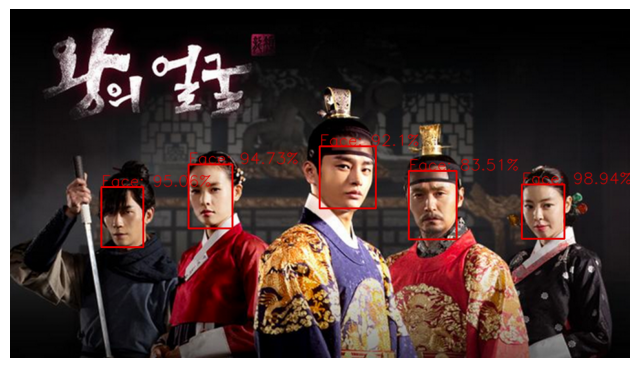

In [39]:
detect = out[0, 0, :, :]
h, w = img.shape[:2]

for i in range(detect.shape[0]):
    confidence = detect[i, 2]

    if confidence > 0.15:
        x1 = int(detect[i, 3]*w)
        y1 = int(detect[i, 4]*h)
        x2 = int(detect[i, 5]*w)
        y2 = int(detect[i, 6]*h)

        cv2.rectangle(img, (x1, y1), (x2, y2),
                      (0, 0, 225), 2)
        text = f'Face: {round(confidence*100, 2)}%'
        cv2.putText(img, text, (x1, y1-1), cv2.FONT_HERSHEY_SIMPLEX,
                    0.8, (0, 0, 225), 1, cv2.LINE_AA)
        
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8,8))
plt.imshow(img)
plt.grid(None)
plt.axis('off')
plt.show()

In [40]:
import numpy as np
from sklearn.cluster import KMeans

bboxes = np.array([[32, 32], [64, 64], 
                   [128, 128], [256, 256], 
                   [512, 512], [128, 64], 
                   [64, 128], [256, 128]])

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(bboxes)

anchors = kmeans.cluster_centers_
print(anchors)

c:\Users\ASUS\.conda\envs\ML_lecture\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[[512.  512. ]
 [ 83.2  83.2]
 [256.  192. ]]


In [42]:
import sys
import numpy as np
import cv2

model = './yolo_v3_pb/yolov3.weights'
config = './yolo_v3_pb/yolov3.cfg'
class_labels = './yolo_v3_pb/coco.names'

img_files = ['./figure/dog.jpg', 
             './figure/person.jpg', 
             './figure/sheep.jpg', 
             './figure/kite.jpg']

net = cv2.dnn.readNet(model, config)

if net.empty():
    print('Net open failed!')
    sys.exit()

classes = []

with open(class_labels, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

net.getUnconnectedOutLayers()
layer_names = net.getLayerNames()
output_layers = [layer_names[i-1] for i in net.getUnconnectedOutLayers()]
print(output_layers)

['yolo_82', 'yolo_94', 'yolo_106']


['./figure/dog.jpg', './figure/person.jpg', './figure/sheep.jpg', './figure/kite.jpg']


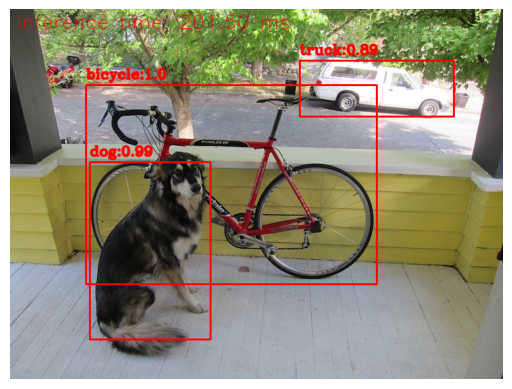

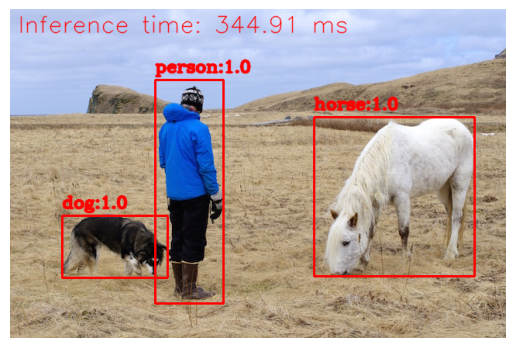

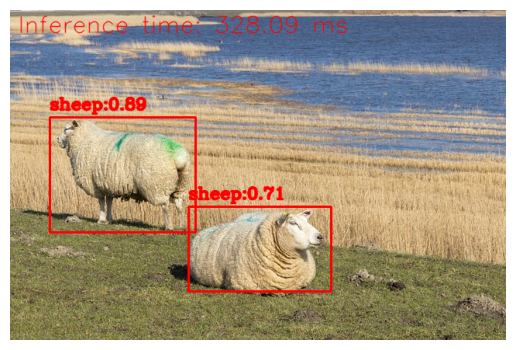

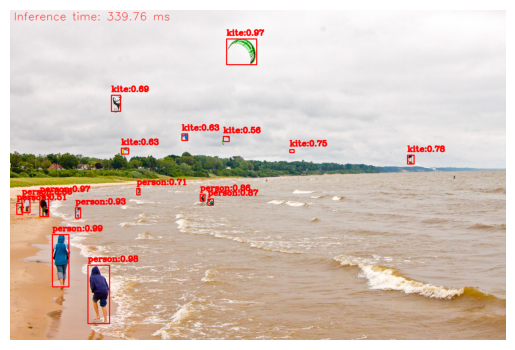

In [46]:
import time

confThreshold = 0.5
nmsThreshold = 0.4

print(img_files)

for i in img_files:
    img = cv2.imread(i)

    if img is None:
        continue

    blob = cv2.dnn.blobFromImage(img, 1/255., (320, 320), swapRB=True)

    net.setInput(blob)
    outs = net.forward(output_layers)

    h, w = img.shape[:2]

    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > confThreshold:
                cx = int(detection[0]*w)
                cy = int(detection[1]*h)
                bw = int(detection[2]*w)
                bh = int(detection[3]*h)

                sx = int(cx - bw / 2)
                sy = int(cy - bh / 2)

                boxes.append([sx, sy, bw, bh])
                confidences.append(float(confidence))
                class_ids.append(int(class_id))

    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)

    for i in indices:
        sx, sy, bw, bh = boxes[i]
        label = f'{classes[class_ids[i]]}:{confidences[i]:.2}'
        color = (0, 0, 255)
        cv2.rectangle(img, (sx, sy, bw, bh), color, 2)
        cv2.putText(img, label, (sx, sy-10),
                    cv2.FONT_HERSHEY_COMPLEX, 0.7, color, 2, cv2.LINE_AA)
    
    t, _ = net.getPerfProfile()
    label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())

    cv2.putText(img, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 1, cv2.LINE_AA)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')
    plt.show()